In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import re
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\82108\anaconda3\envs\env1_py37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
index2region={0:'gangwon', 1:'gyeongsang', 2:'jeonla', 3:'chungcheong', 4:'jeju'}
region2index = {v:k for k,v in index2region.items()}
region_shortening = ['GW','GS','JL','CC','JJ']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# 데이터 셋 구성 (small dataset)
dataset_dir = 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\'

In [4]:
region_dir = glob(dataset_dir)
region_dir

['c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\']

In [5]:
for k, v in index2region.items():
    exec(f"{v}_dirs = glob(dataset_dir+'*_{v}/*')")
jeonla_dirs

['c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000005',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000006',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000012',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000014',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000015',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000018',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000019',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\CNN_Dialect_Classification3\\data\\preprocessed_jeonla\\DJDD20000024',
 'c:\\Users\\82108\\anaconda3\\envs\\env1_py37\\

In [6]:
def make_tuple_data(dirs, max_num):
    for i, region_dir in enumerate(dirs):
        if i>=max_num:break
        spectro_path = glob(region_dir+'/*_spectro.pickle')[0]
        mfcc_path = glob(region_dir+'/*_mfcc.pickle')[0]
        chroma_path = glob(region_dir+'/*_chroma.pickle')[0]
        
        with open(spectro_path, "rb") as f:
            spectro = pickle.load(f)
        with open(mfcc_path, "rb") as f:
            mfcc = pickle.load(f)
        with open(chroma_path, "rb") as f:
            chroma = pickle.load(f)

        if i == 0:
            spectro_data = spectro
            mfcc_data = mfcc
            chroma_data = chroma
        else:
            spectro_data = np.concatenate([spectro_data,spectro], axis=0)
            mfcc_data = np.concatenate([mfcc_data,mfcc], axis=0)
            chroma_data = np.concatenate([chroma_data,chroma], axis=0)
    if max_num ==0:return []
        
    r_data = [(s,m,c) for s,m,c in zip(spectro_data,mfcc_data,chroma_data)]
        
    return r_data

def make_tuple(max_num=2):
    jeonla_data = make_tuple_data(jeonla_dirs, max_num)
    chungcheong_data = make_tuple_data(chungcheong_dirs, max_num)
    gyeongsang_data = make_tuple_data(gyeongsang_dirs, max_num)
    jeju_data = make_tuple_data(jeju_dirs, max_num)
    gangwon_data = make_tuple_data(gangwon_dirs, max_num)
    return jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data

def print_data(r_data, region):
    if len(r_data)==0: return
    print(f"{region} data num: ", len(r_data))
    print(f"{region} tuple size", len(r_data[0]))
    print(f"{region} spec shape", r_data[0][0].shape)

jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data = make_tuple(1000)
print_data(jeonla_data, 'jeonla')
print_data(chungcheong_data, 'chungcheong')
print_data(gyeongsang_data, 'gyeongsang')
print_data(jeju_data, 'jeju')
print_data(gangwon_data, 'gangwon')

jeonla data num:  913
jeonla tuple size 3
jeonla spec shape (201, 501)
chungcheong data num:  1108
chungcheong tuple size 3
chungcheong spec shape (201, 501)
gyeongsang data num:  842
gyeongsang tuple size 3
gyeongsang spec shape (201, 501)
jeju data num:  756
jeju tuple size 3
jeju spec shape (201, 501)
gangwon data num:  1183
gangwon tuple size 3
gangwon spec shape (201, 501)


In [7]:
jeonla_data_l = []
for data in jeonla_data:
    y = [0,0,0,0,0]
    y[region2index['jeonla']] = 1
    jeonla_data_l.append((data,y))

chungcheong_data_l = []
for data in chungcheong_data:
    y = [0,0,0,0,0]
    y[region2index['chungcheong']] = 1
    chungcheong_data_l.append((data,y))

gyeongsang_data_l = []
for data in gyeongsang_data:
    y = [0,0,0,0,0]
    y[region2index['gyeongsang']] = 1
    gyeongsang_data_l.append((data,y))

jeju_data_l = []
for data in jeju_data:
    y = [0,0,0,0,0]
    y[region2index['jeju']] = 1
    jeju_data_l.append((data,y))

gangwon_data_l = []
for data in gangwon_data:
    y = [0,0,0,0,0]
    y[region2index['gangwon']] = 1
    gangwon_data_l.append((data,y))

In [8]:
datasumup = np.concatenate([jeonla_data_l[:100], chungcheong_data_l[:100], gangwon_data_l[:100], jeju_data_l[:100], gyeongsang_data_l[:100]], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
print(len(jeonla_data))
print(len(jeonla_data[0]))
print(len(jeonla_data[0][0]))
print(jeonla_data[0][0][0].shape)
print(jeonla_data[0][1])

913
3
201
(501,)
[[-8.95968933e+02 -6.80366333e+02 -6.32467224e+02 ... -6.35895569e+02
  -7.37488281e+02 -8.95968933e+02]
 [ 0.00000000e+00  1.05635895e+02  9.15234528e+01 ...  1.30098984e+02
   1.36352631e+02  0.00000000e+00]
 [ 0.00000000e+00  1.99494553e+01  3.10183601e+01 ...  3.71154938e+01
   5.05742950e+01  0.00000000e+00]
 ...
 [ 0.00000000e+00 -2.89541364e-01 -3.26715827e+00 ... -1.02442813e+00
  -2.09881973e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.61979103e+00 -2.14631224e+00 ... -2.70997930e+00
  -2.80001187e+00  0.00000000e+00]
 [ 0.00000000e+00  3.62961203e-01  3.42702985e+00 ... -1.51727200e-01
  -2.38134336e+00  0.00000000e+00]]


In [10]:
from sklearn.preprocessing import normalize
class MultiModalDataset(Dataset):

    def __init__(self, data):

        self.data = data

    def __getitem__(self, idx):
        datas, label = self.data[idx]
        spec, mfcc, chroma = datas
        spec, mfcc, chroma = normalize(spec), normalize(mfcc), normalize(chroma)
        spec, mfcc, chroma = torch.tensor(spec, dtype=torch.float32), torch.tensor(mfcc, dtype=torch.float32), torch.tensor(chroma, dtype=torch.float32)
        spec, mfcc, chroma = spec.unsqueeze(0), mfcc.unsqueeze(0), chroma.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)

        data = (spec, mfcc, chroma)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [11]:
dataset = MultiModalDataset(datasumup)
len(dataset)

500

In [12]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.seq1 = nn.Sequential(self.conv1, self.bn1, self.relu)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.seq2 = nn.Sequential(self.conv2, self.bn2)
        
        self.down_flag = False
        if in_channels != out_channels: self.down_flag = True

        self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=2, padding=0, bias=False)
    
    def forward(self, x):
        #print(x.shape)
        y = self.seq1(x)
        #print(y.shape)
        y = self.seq2(y)
        #print(y.shape)

        if self.down_flag:
            x = self.downsample(x)
        
        y = self.relu(y)
        #print(x.shape)
        #print(y.shape)
        y = y + x

        return y
        

In [13]:
class ResNet18(nn.Module):

    def __init__(self, in_channels, output_dim=128, model_type='spec'):
        super(ResNet18, self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
        self.BN1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.seq1 = nn.Sequential(self.conv1, self.BN1, self.pool1)

        self.seq2 = nn.Sequential(BasicBlock(64,64), BasicBlock(64,64))
        self.seq3 = nn.Sequential(BasicBlock(64,64), BasicBlock(64, 128, stride=2))
        self.seq4 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,128))
        self.seq5 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,256,stride=2))

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1,1))
        # if model_type=='spec':
        #     self.fc1 = nn.Linear(256*13*32, output_dim)
        # elif model_type=='mfcc':
        #     self.fc1 = nn.Linear(256*7*32, output_dim)
        # elif model_type=='chroma':
        #     self.fc1 = nn.Linear(256*1*32, output_dim)
        self.fc1 = nn.Linear(256, output_dim)


        self.lastlayer = nn.Sequential(self.fc1, self.relu)

    def forward(self, x):
        y = self.seq1(x)
        y = self.seq2(y)
        y = self.seq3(y)
        y = self.seq4(y)
        y = self.seq5(y)
        y = self.avg_pool1(y)
        y = y.view(y.shape[0],-1)
        y = self.lastlayer(y)

        return y



In [14]:
class MultiModalDialectClassifier(nn.Module):

    def __init__(self, hidden_dim=1024, out_dim=5, learning_rate=0.01, best_model_save_path="./best_model.pt"):
        super(MultiModalDialectClassifier, self).__init__()

        self.best_model_save_path = best_model_save_path
        self.spec_res = ResNet18(1, model_type='spec')
        self.mfcc_res = ResNet18(1, model_type='mfcc')
        self.chroma_res = ResNet18(1, model_type='chroma')
        

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*3, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128,out_dim)
        self.lastlayer = nn.Sequential(self.fc1, self.dropout1, self.relu, self.fc2)

        self.loss_f = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        #self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        spec_x, mfcc_x, chroma_x = x

        spec_y = self.spec_res(spec_x)
        mfcc_y = self.mfcc_res(mfcc_x)
        chroma_y = self.chroma_res(chroma_x)

        y = torch.cat([spec_y, mfcc_y, chroma_y], dim=1)
        y = y.view(y.shape[0], -1)
        
        y = self.lastlayer(y)
        #y = self.softmax(y)
        #print(y.shape)
        return y
    
    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None
        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                if epoch==epochs: #last epoch
                    self.pred_labels_train.append(pred_indices)
                    self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            if epoch==epochs: #last epoch
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./model_{which}.png")
        plt.show()

    def getConvLayers(self, resnet):
        weights = []
        conv_layers = []
        for i in range(len(resnet)):
            if type(resnet[i]) == nn.Conv2d:
                weights.append(resnet[i].weight)
                conv_layers.append(resnet[i])
            elif type(resnet[i]) == nn.Sequential:
                for basic in resnet[i].children(): # basic block
                    for in_basic in basic.children():
                        if type(in_basic) == nn.Conv2d:
                            weights.append(in_basic.weight)
                            conv_layers.append(in_basic)
                        if type(in_basic) == nn.Sequential:
                            for in_basic_in_sequential in in_basic:
                                if type(in_basic_in_sequential) == nn.Conv2d:
                                    weights.append(in_basic_in_sequential.weight)
                                    conv_layers.append(in_basic_in_sequential)            
        return weights, conv_layers

    def extractConvLayer(self):
        children_ = list(self.children())
        spec_resnet = list(children_[0].children())
        mfcc_resnet = list(children_[1].children())
        chroma_resnet = list(children_[2].children()) 

        spec_weights, spec_layers = self.getConvLayers(spec_resnet)
        mfcc_weights, mfcc_layers = self.getConvLayers(mfcc_resnet)
        chroma_weights, chroma_layers = self.getConvLayers(chroma_resnet)

        self.spec_weights = spec_weights
        self.spec_layers = spec_layers
        self.mfcc_weights = mfcc_weights
        self.mfcc_layers = mfcc_layers
        self.chroma_weights = chroma_weights
        self.chroma_layers = chroma_layers
        
        return spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers

    def plotFilter(self, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            filters = self.spec_weights
        elif data_type == 'mfcc':
            filters = self.mfcc_weights
        elif data_type == 'chroma':
            filters = self.chroma_weights
        x_len = 0
        y_len = 0
        if where=='first': # 64x1x7x7
            filters = filters[0]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(20,17))
            x_len=8
            y_len=8
        elif where=='middle': # 128x64x3x3
            filters = filters[16]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(30,25))
            x_len= 16
            y_len= 8
        elif where=='last': # 256x256x3x3
            filters = filters[len(filters)-2]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(40,32))
            x_len=16
            y_len=16
        for i,filter in enumerate(filters):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(filter.detach().cpu(), cmap='gray')
            plt.axis('off')
        plt.savefig(f"./{data_type}_filter_{where}_{when}.png")
        plt.show()
        plt.close()
    
    def plotOriginalImage(self, data):
        plt.imshow(data[0,:,:])
        plt.show()

    def plotFeatureMap(self, data, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            layers = self.spec_layers
            x_len = 8
            y_len = 8
        elif data_type == 'mfcc':
            layers = self.mfcc_layers
            x_len = 16
            y_len = 4
        elif data_type == 'chroma':
            layers = self.chroma_layers
            x_len = 32
            y_len = 2

        if where=='first':
            plt.figure(figsize=(20,17))
            layer = layers[0]
        elif where=='middle':
            pass
        elif where=='last':
            pass
        results = layer(data) # 64x?x251
        for i, result in enumerate(results):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(result.detach().cpu())
            plt.axis('off')
        plt.savefig(f"./{data_type}_feature_map_{where}_{when}.png")
        plt.show()
        plt.close()      

        
        
        

In [15]:
def Kfold_train(dataset, learning_rate, epochs, device):
        hparams = []
        for i in range(len(learning_rate)):
            for j in range(len(epochs)):
                hparams.append((learning_rate[i], epochs[j]))
        print(hparams)

        train_size = int(len(dataset)*0.8)
        validation_size = len(dataset) - train_size

        train_dataset_l = []
        validation_dataset_l = []

        for i in range(5):
            train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
            train_dataset_l.append(train_dataset)
            validation_dataset_l.append(validation_dataset)

        res = []
        for i in range(len(hparams)):
            lr = hparams[i][0]
            e = hparams[i][1]
            print(f"Learning rate : {lr}, Epochs : {e}")

            last_val_acc = []
            model = MultiModalDialectClassifier().to(device)
            for j in range(5):
                print(f"#{j+1} validation")
                train_loader = DataLoader(train_dataset_l[j], batch_size=32, shuffle=True)
                validation_loader = DataLoader(validation_dataset_l[j], batch_size=32, shuffle=True)

                model.train_(train_loader, validation_loader, lr, e, device)
                last_val_acc.append(model.val_accuracy[-1])
                model.plot('train_acc')
                model.plot('val_acc')

            res.append((np.array(last_val_acc)).mean())
        idx = res.index(max(res))
        
        best_lr, best_ep = hparams[idx]

        print(f"Best Learning Rate : {best_lr}, Best Epoch : {best_ep}")

        return best_lr, best_ep

[(0.001, 2), (0.0005, 2)]
Learning rate : 0.001, Epochs : 2
#1 validation


100%|██████████| 13/13 [00:15<00:00,  1.16s/it]


epoch 1 time: 15.040756225585938sec(s).
epoch 1 train accuracy: 0.3575
epoch 1 loss: 2.707323441138634


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


epoch 1 val accuracy: 0.25
epoch 1 val loss: 32.0175666809082


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


epoch 2 time: 13.598219156265259sec(s).
epoch 2 train accuracy: 0.7
epoch 2 loss: 0.8264658313531142


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


epoch 2 val accuracy: 0.25
epoch 2 val loss: 113.39416122436523
Finish!


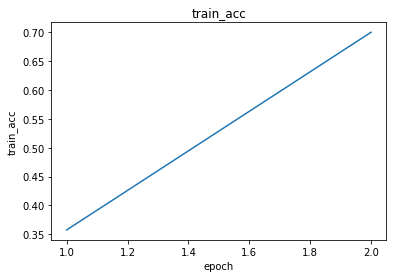

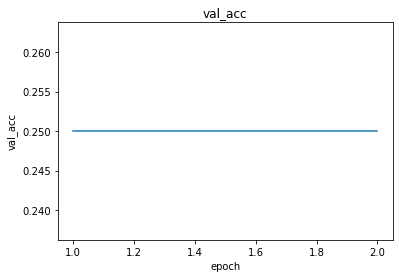

#2 validation


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


epoch 1 time: 7.591002702713013sec(s).
epoch 1 train accuracy: 0.7225
epoch 1 loss: 0.9469552590296819


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 1 val accuracy: 0.22
epoch 1 val loss: 78.40437698364258


100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


epoch 2 time: 6.427014112472534sec(s).
epoch 2 train accuracy: 0.8225
epoch 2 loss: 0.5174492712204273


100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

epoch 2 val accuracy: 0.19
epoch 2 val loss: 6.671702265739441
Finish!


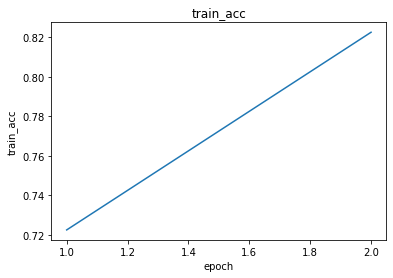

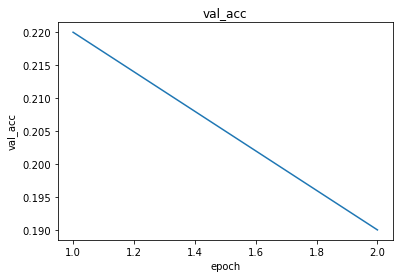

#3 validation


100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


epoch 1 time: 6.4009716510772705sec(s).
epoch 1 train accuracy: 0.79
epoch 1 loss: 0.6299423071054312


100%|██████████| 4/4 [00:00<00:00,  7.25it/s]


epoch 1 val accuracy: 0.15
epoch 1 val loss: 11.457546949386597


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


epoch 2 time: 6.294212818145752sec(s).
epoch 2 train accuracy: 0.885
epoch 2 loss: 0.30811999623592085


100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

epoch 2 val accuracy: 0.31
epoch 2 val loss: 10.658338189125061
Finish!


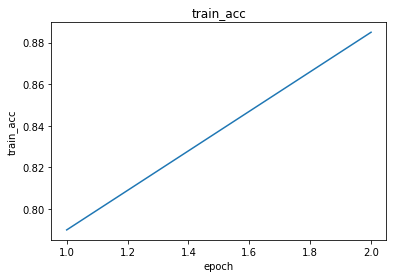

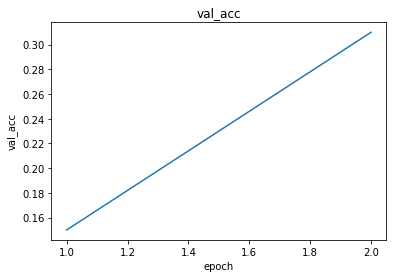

#4 validation


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


epoch 1 time: 6.667465448379517sec(s).
epoch 1 train accuracy: 0.71
epoch 1 loss: 0.9873201640752646


100%|██████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 1 val accuracy: 0.69
epoch 1 val loss: 0.9841198474168777


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


epoch 2 time: 7.015717029571533sec(s).
epoch 2 train accuracy: 0.7475
epoch 2 loss: 0.8395282626152039


100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

epoch 2 val accuracy: 0.54
epoch 2 val loss: 3.114174008369446
Finish!


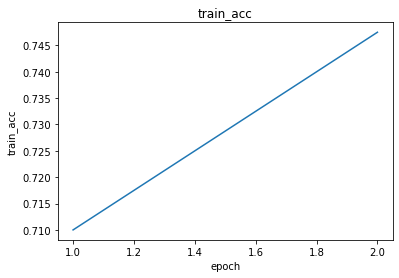

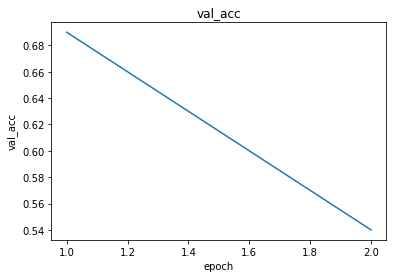

#5 validation


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


epoch 1 time: 8.179928302764893sec(s).
epoch 1 train accuracy: 0.6375
epoch 1 loss: 1.3242182273131151


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 1 val accuracy: 0.36
epoch 1 val loss: 6.726686716079712


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


epoch 2 time: 8.797998666763306sec(s).
epoch 2 train accuracy: 0.6475
epoch 2 loss: 0.8865764462030851


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]

epoch 2 val accuracy: 0.61
epoch 2 val loss: 0.8777697533369064
Finish!


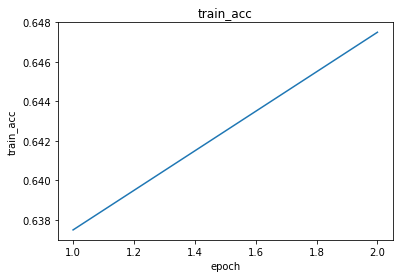

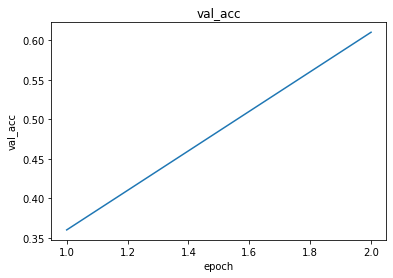

Learning rate : 0.0005, Epochs : 2
#1 validation


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


epoch 1 time: 6.7319722175598145sec(s).
epoch 1 train accuracy: 0.2875
epoch 1 loss: 1.9518976670045118


100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


epoch 1 val accuracy: 0.25
epoch 1 val loss: 126.40869140625


100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


epoch 2 time: 6.922000169754028sec(s).
epoch 2 train accuracy: 0.6275
epoch 2 loss: 0.9919008750181931


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

epoch 2 val accuracy: 0.25
epoch 2 val loss: 6.772632598876953
Finish!


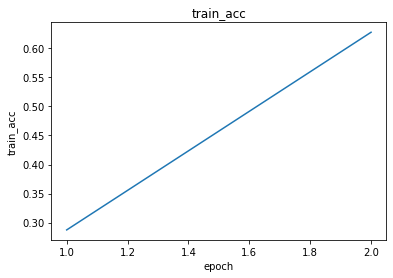

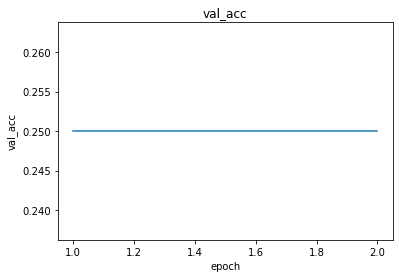

#2 validation


100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


epoch 1 time: 7.276132345199585sec(s).
epoch 1 train accuracy: 0.6375
epoch 1 loss: 1.0125599136719337


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


epoch 1 val accuracy: 0.2
epoch 1 val loss: 9.21447765827179


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


epoch 2 time: 6.289124488830566sec(s).
epoch 2 train accuracy: 0.73
epoch 2 loss: 0.7237436312895554


100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

epoch 2 val accuracy: 0.2
epoch 2 val loss: 9.06060528755188
Finish!


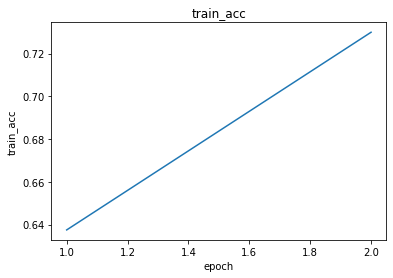

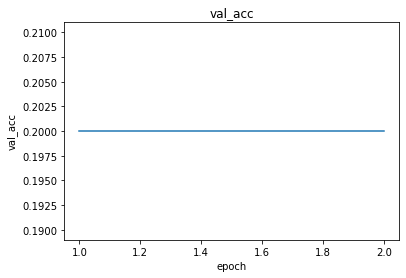

#3 validation


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


epoch 1 time: 6.830641508102417sec(s).
epoch 1 train accuracy: 0.805
epoch 1 loss: 0.6003904732374045


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 1 val accuracy: 0.48
epoch 1 val loss: 3.6189783811569214


100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


epoch 2 time: 6.546962738037109sec(s).
epoch 2 train accuracy: 0.735
epoch 2 loss: 0.7697301598695608


100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

epoch 2 val accuracy: 0.43
epoch 2 val loss: 2.8123152405023575
Finish!


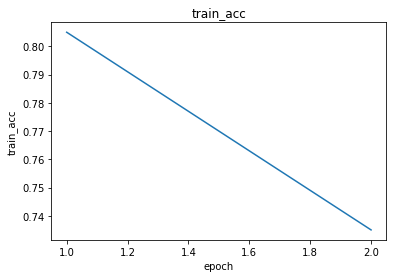

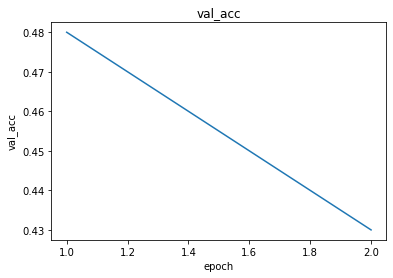

#4 validation


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


epoch 1 time: 6.860518455505371sec(s).
epoch 1 train accuracy: 0.7375
epoch 1 loss: 0.7408263706243955


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


epoch 1 val accuracy: 0.78
epoch 1 val loss: 0.5966307148337364


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


epoch 2 time: 6.27503776550293sec(s).
epoch 2 train accuracy: 0.8
epoch 2 loss: 0.5857735276222229


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

epoch 2 val accuracy: 0.27
epoch 2 val loss: 9.257462739944458
Finish!


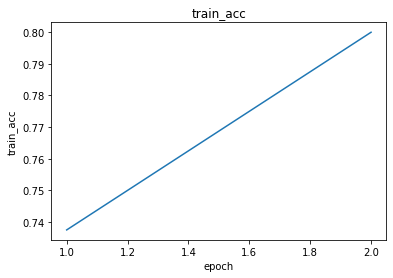

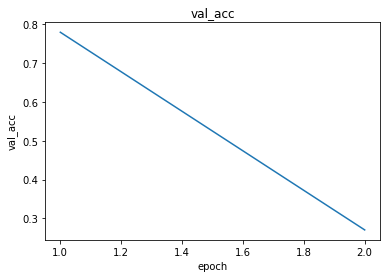

#5 validation


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


epoch 1 time: 6.962146997451782sec(s).
epoch 1 train accuracy: 0.805
epoch 1 loss: 0.6128893059033614


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


epoch 1 val accuracy: 0.71
epoch 1 val loss: 1.2361014038324356


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


epoch 2 time: 6.656002044677734sec(s).
epoch 2 train accuracy: 0.855
epoch 2 loss: 0.47697420303638166


100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

epoch 2 val accuracy: 0.82
epoch 2 val loss: 0.4114319644868374
Finish!


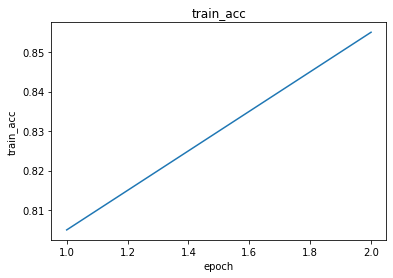

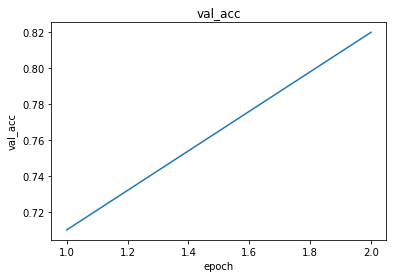

Best Learning Rate : 0.0005, Best Epoch : 2


In [16]:
lr = [0.001, 0.0005]
ep = [2]

best_lr, best_ep = Kfold_train(dataset, learning_rate= lr, epochs= ep, device = device)

In [17]:
print(best_lr, best_ep)

0.0005 2
